In [31]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 

# Load data from CSV files into DataFrames
customers = pd.read_csv(r'C:\Users\jared\Downloads\e-Commerce (Target) Sales Dataset\customers.csv')
geolocations = pd.read_csv(r'C:\Users\jared\Downloads\e-Commerce (Target) Sales Dataset\geolocation.csv')
order_items = pd.read_csv(r'C:\Users\jared\Downloads\e-Commerce (Target) Sales Dataset\order_items.csv')
orders = pd.read_csv(r'C:\Users\jared\Downloads\e-Commerce (Target) Sales Dataset\orders.csv')
payments = pd.read_csv(r'C:\Users\jared\Downloads\e-Commerce (Target) Sales Dataset\payments.csv')
products = pd.read_csv(r'C:\Users\jared\Downloads\e-Commerce (Target) Sales Dataset\products.csv')
sellers = pd.read_csv(r'C:\Users\jared\Downloads\e-Commerce (Target) Sales Dataset\sellers.csv')

# Display first few rows of each DataFrame for verification
print(customers.head())
print(geolocations.head())
print(order_items.head())
print(orders.head())
print(payments.head())
print(products.head())
print(sellers.head())

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                

In [13]:
# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Write DataFrames to the SQLite database as tables
customers.to_sql('customers', conn, index=False, if_exists='replace')
geolocations.to_sql('geolocations', conn, index=False, if_exists='replace')
order_items.to_sql('order_items', conn, index=False, if_exists='replace')
orders.to_sql('orders', conn, index=False, if_exists='replace')
payments.to_sql('payments', conn, index=False, if_exists='replace')
products.to_sql('products', conn, index=False, if_exists='replace')
sellers.to_sql('sellers', conn, index=False, if_exists='replace')

# Verify that tables were created
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in SQLite database:")
print(tables)

Tables in SQLite database:
           name
0     customers
1  geolocations
2   order_items
3        orders
4      payments
5      products
6       sellers


C:\Users\jared\anaconda3\lib\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


                 customer_unique_id  lifetime_spent  spending_rank
0  0a0a92112bd4c708ca5fde585afaa872         13440.0              1
1  da122df9eeddfedc1dc1f5349a1a690c          7388.0              2
2  763c8b1c9c68a0229c42c9fc6f662b93          7160.0              3
3  dc4802a71eae9be1dd28f5d788ceb526          6735.0              4
4  459bef486812aa25204be022145caa62          6729.0              5
5  ff4159b92c40ebe40454e3e6a7c35ed6          6499.0              6
6  4007669dec559734d6f53e029e360987          5934.6              7
7  eebb5dda148d3893cdaf5b5ca3040ccb          4690.0              8
8  5d0a2980b292d049061542014e8960bf          4599.9              9
9  48e1ac109decbb87765a3eade6854098          4590.0             10


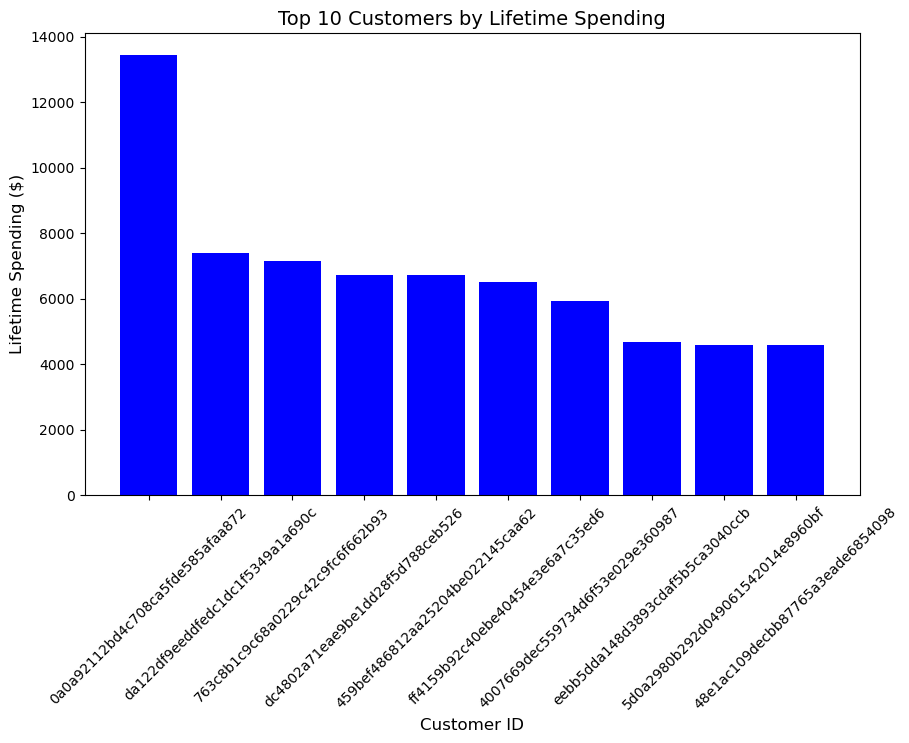

In [40]:
# Customer Analysis

# Rank Customers by Lifetime Spending

query = """
SELECT 
    c.customer_unique_id,
    SUM(oi.price) AS lifetime_spent,
    RANK() OVER (ORDER BY SUM(oi.price) DESC) AS spending_rank
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_unique_id
ORDER BY spending_rank
LIMIT 10;
"""
customer_ranking = pd.read_sql(query, conn)
print(customer_ranking)

# Chart

plt.figure(figsize=(10, 6))
plt.bar(customer_ranking['customer_unique_id'], customer_ranking['lifetime_spent'], color='blue')
plt.title('Top 10 Customers by Lifetime Spending', fontsize=14)
plt.xlabel('Customer ID', fontsize=12)
plt.ylabel('Lifetime Spending ($)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

    purchase_date  daily_sales  running_total_sales
0      2016-09-04        72.89                72.89
1      2016-09-05        59.50               132.39
2      2016-09-15       134.97               267.36
3      2016-10-02       100.00               367.36
4      2016-10-03       463.48               830.84
..            ...          ...                  ...
611    2018-08-26      8070.71          13580932.84
612    2018-08-27      5345.91          13586278.75
613    2018-08-28      3673.91          13589952.66
614    2018-08-29      1546.04          13591498.70
615    2018-09-03       145.00          13591643.70

[616 rows x 3 columns]


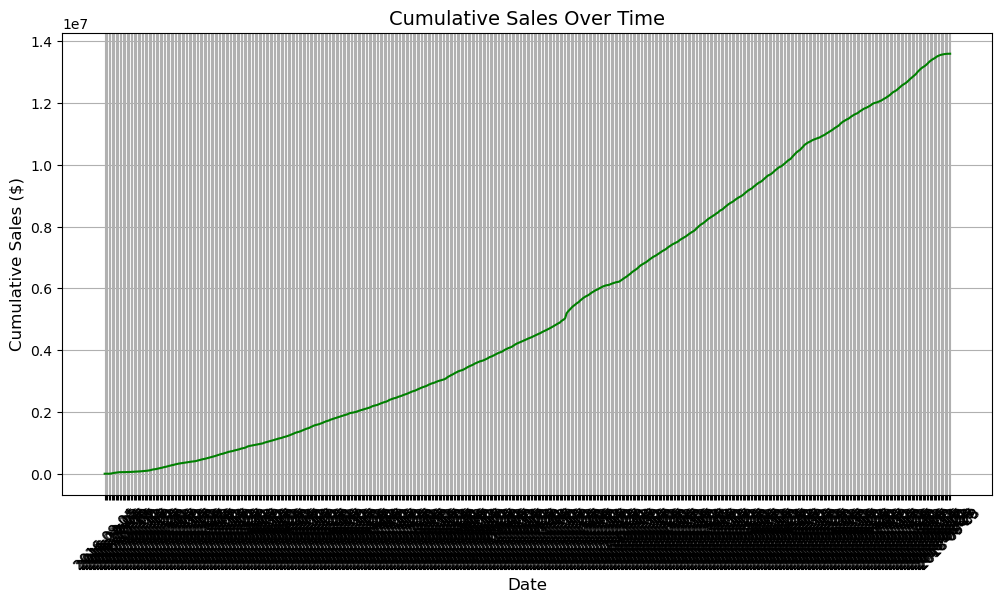

In [35]:
# Sales Performance

# Running Total of Daily Sales

query = """
SELECT 
    DATE(o.order_purchase_timestamp) AS purchase_date,
    SUM(oi.price) AS daily_sales,
    SUM(SUM(oi.price)) OVER (ORDER BY DATE(o.order_purchase_timestamp)) AS running_total_sales
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY purchase_date
ORDER BY purchase_date;
"""
daily_sales_with_running_total = pd.read_sql(query, conn)
print(daily_sales_with_running_total)

# Chart

plt.figure(figsize=(12, 6))
plt.plot(daily_sales_with_running_total['purchase_date'], daily_sales_with_running_total['running_total_sales'], color='green')
plt.title('Cumulative Sales Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.show()


    purchase_date  daily_sales  moving_avg_sales
0      2016-09-04        72.89         72.890000
1      2016-09-05        59.50         66.195000
2      2016-09-15       134.97         89.120000
3      2016-10-02       100.00         91.840000
4      2016-10-03       463.48        166.168000
..            ...          ...               ...
611    2018-08-26      8070.71      18062.041429
612    2018-08-27      5345.91      13900.100000
613    2018-08-28      3673.91      10664.507143
614    2018-08-29      1546.04       7985.780000
615    2018-09-03       145.00       5573.512857

[616 rows x 3 columns]


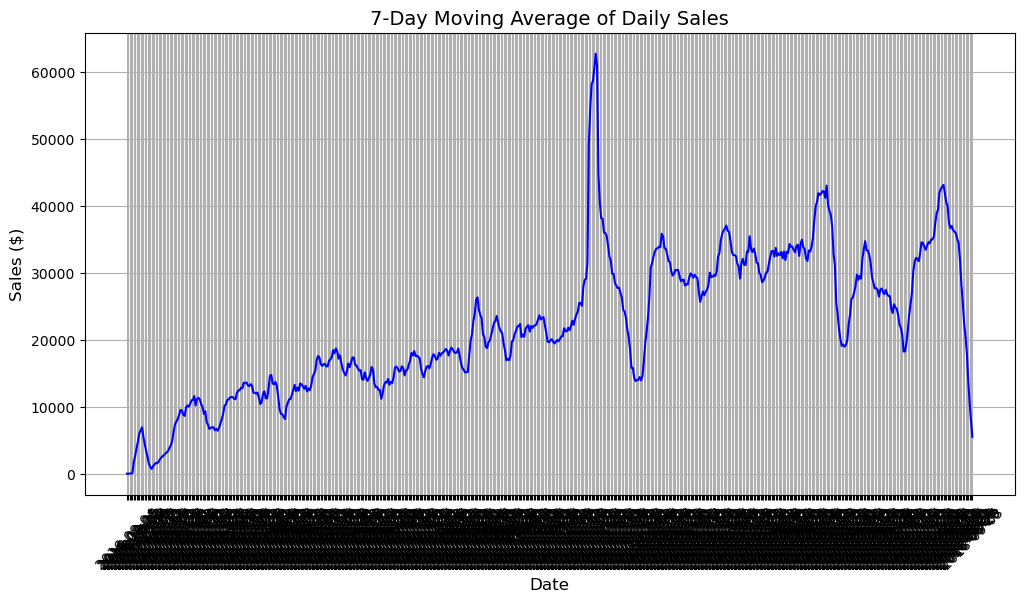

In [36]:
# Moving Average of Daily Sales
query = """
SELECT 
    DATE(o.order_purchase_timestamp) AS purchase_date,
    SUM(oi.price) AS daily_sales,
    AVG(SUM(oi.price)) OVER (
        ORDER BY DATE(o.order_purchase_timestamp) 
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) AS moving_avg_sales
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY purchase_date
ORDER BY purchase_date;
"""
moving_avg_sales = pd.read_sql(query, conn)
print(moving_avg_sales)

# Chart
plt.figure(figsize=(12, 6))
plt.plot(moving_avg_sales['purchase_date'], moving_avg_sales['moving_avg_sales'], color='blue')
plt.title('7-Day Moving Average of Daily Sales', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.show()


  customer_state  avg_delay_days  delay_rank
0             AL       -8.032059           1
1             MA       -8.887844           2
2             SE       -9.328641           3
3             ES       -9.797109           4
4             BA      -10.099073           5
5             CE      -10.110007           6
6             MS      -10.355558           7
7             SP      -10.380350           8
8             PI      -10.629538           9
9             SC      -10.801736          10


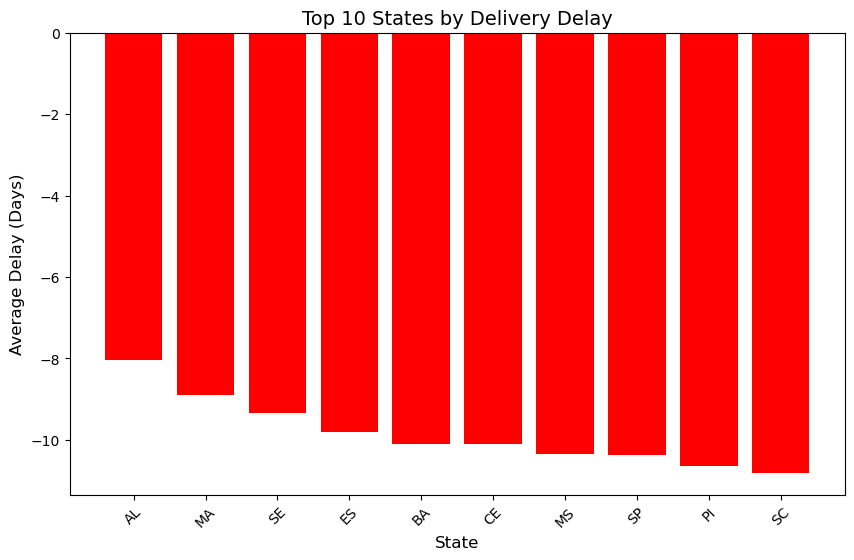

In [39]:
# Delivery Performance

# Average Delivery Delay by State

query = """
SELECT 
    c.customer_state,
    AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date)) AS avg_delay_days,
    RANK() OVER (ORDER BY AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date)) DESC) AS delay_rank
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_state
ORDER BY delay_rank
LIMIT 10;
"""
delivery_delays_ranked = pd.read_sql(query, conn)
print(delivery_delays_ranked)

# Chart

plt.figure(figsize=(10, 6))
plt.bar(delivery_delays_ranked['customer_state'], delivery_delays_ranked['avg_delay_days'], color='red')
plt.title('Top 10 States by Delivery Delay', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Delay (Days)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

